In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.io.gfile import glob
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import PIL
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
### Setting my path to the input file
#os.chdir("/kaggle/input/gan-getting-started")
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, len(os.listdir(dirname)))
AUTOTUNE = tf.data.experimental.AUTOTUNE


/kaggle/input 0


In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/My Drive/gan-getting-started

/content/drive/My Drive/gan-getting-started


In [27]:
Monet_files = glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(Monet_files))
Photo_files = glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(Photo_files))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [28]:
raw_dataset = tf.data.TFRecordDataset(Monet_files[0])
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    Monet_features = [i for i in example.features.feature]

raw_dataset = tf.data.TFRecordDataset(Photo_files[0])
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    Photo_features = [i for i in example.features.feature]

print('Monet tfrecord Features:', Monet_features)
print('Photo tfrecord Features:', Photo_features)

Monet tfrecord Features: ['image_name', 'image', 'target']
Photo tfrecord Features: ['image_name', 'target', 'image']


In [29]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False, repeat = False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if repeat:
        dataset = dataset.repeat(count = 20)
    dataset = dataset.shuffle(1000)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [30]:
batch_size = 15
photo_ds = load_dataset(Photo_files, labeled = True).batch(15)
monet_ds = load_dataset(Monet_files, labeled = True, repeat = True).batch(15)
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

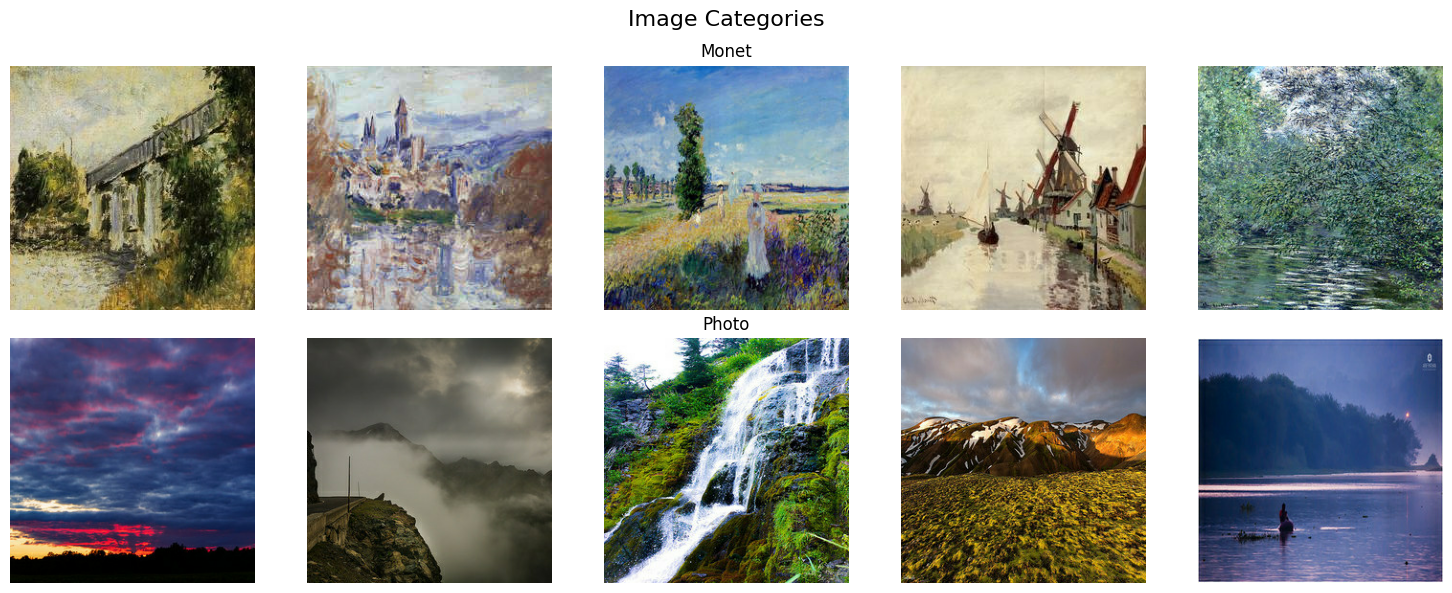

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle('Image Categories', fontsize=16)

for i in range(0,5):
    ax = axes[0, i]
    ax.imshow(example_monet[i])
    ax.axis('off')

for i in range(0,5):
    ax = axes[1, i]
    ax.imshow(example_photo[i])
    ax.axis('off')

axes[0, 2].set_title('Monet', size='large', loc='center')
axes[1, 2].set_title('Photo', size='large', loc='center')
plt.tight_layout()  # Adjust layout to make room for the main title
plt.show()